# 9장 나를 찾아줘 - Class Activation Map 만들기 [프로젝트]

|평가문항|상세기준|
|------|------|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|	CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|	CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|




## 라이브러리 버전 확인하기

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


## 데이터 불러오기

In [ ]:
from tensorflow import keras

import matplotlib.pyplot as plt

import copy
from PIL import Image

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


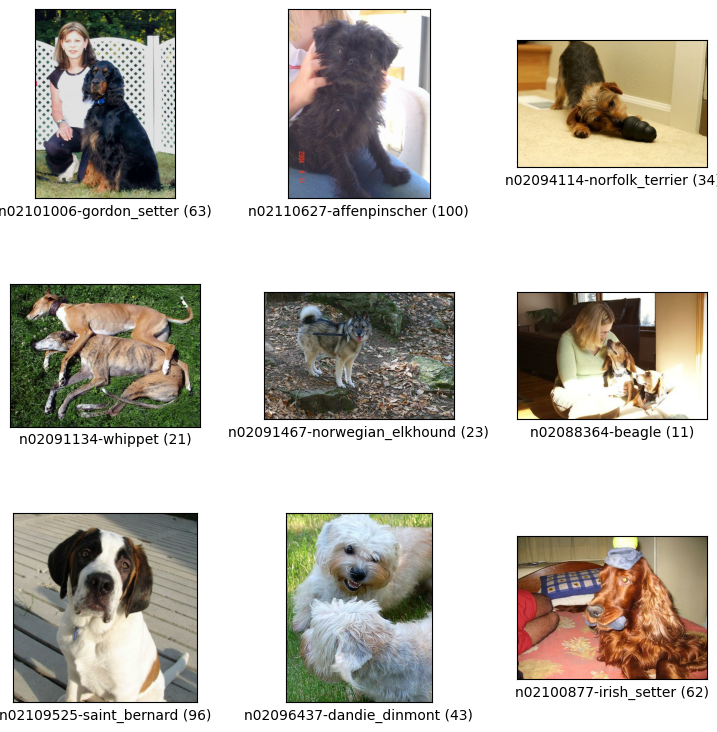

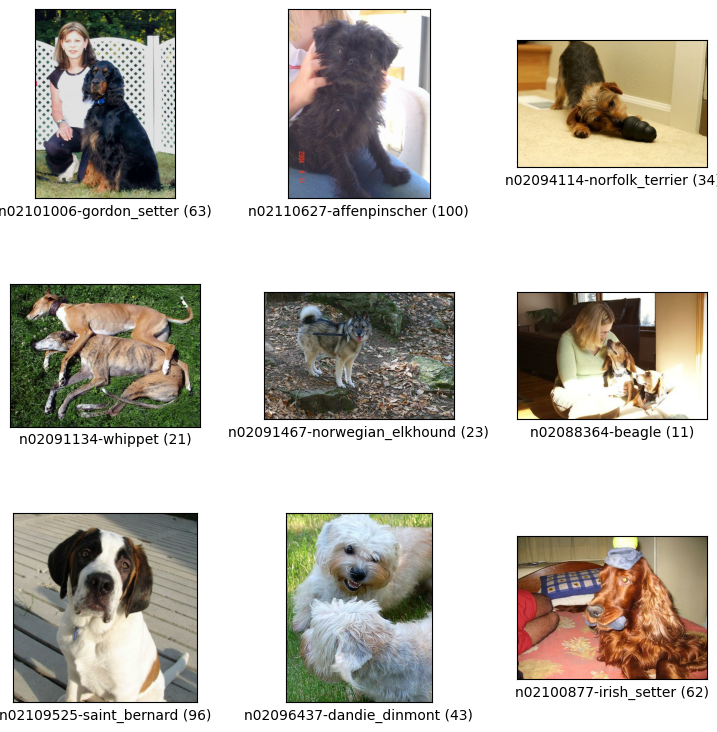

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

##  CAM을 구하기 위한 기본 모델 구현하기

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x) #code 작성
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x) #code 작성
cam_model2 = keras.Model(inputs=base_model.input, outputs=preds)

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
cam_model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model1 = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 160s 209ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.0250 - val_accuracy: 0.7389
Epoch 2/2
750/750 [==============================] - 156s 208ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 1.0312 - val_accuracy: 0.7353


In [ ]:
history_cam_model2 = cam_model2.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 176s 229ms/step - loss: 2.2554 - accuracy: 0.4328 - val_loss: 3.9012 - val_accuracy: 0.1291
Epoch 2/10
750/750 [==============================] - 157s 209ms/step - loss: 0.6391 - accuracy: 0.8332 - val_loss: 1.1627 - val_accuracy: 0.6646
Epoch 3/10
750/750 [==============================] - 156s 209ms/step - loss: 0.1767 - accuracy: 0.9708 - val_loss: 1.0076 - val_accuracy: 0.7149
Epoch 4/10
750/750 [==============================] - 156s 209ms/step - loss: 0.0611 - accuracy: 0.9957 - val_loss: 0.9833 - val_accuracy: 0.7271
Epoch 5/10
750/750 [==============================] - 156s 208ms/step - loss: 0.0288 - accuracy: 0.9988 - val_loss: 0.9708 - val_accuracy: 0.7355
Epoch 6/10
750/750 [==============================] - 156s 208ms/step - loss: 0.0204 - accuracy: 0.9992 - val_loss: 0.9851 - val_accuracy: 0.7337
Epoch 7/10
750/750 [==============================] - 156s 208ms/step - loss: 0.0146 - accuracy: 0.9995 - val_loss: 0.9766 -

## CAM 구현하기

이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [ ]:
def generate_cam(model, item):
    # TODO: generate cam image
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

만든 함수로 CAM 이미지를 생성합시다.

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


67


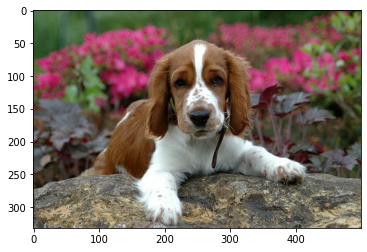

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

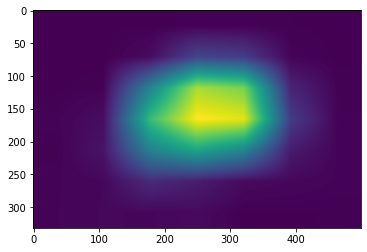

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

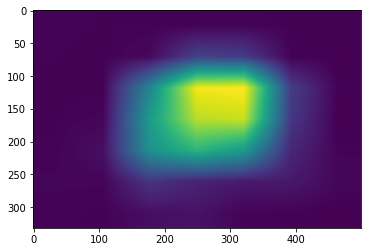

In [ ]:
cam_image2 = generate_cam(cam_model2, item)
plt.imshow(cam_image2)

원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [ ]:
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = cv2.addWeighted(image, 0.5, cam_image, 0.5, 0.0)
    return merged_image

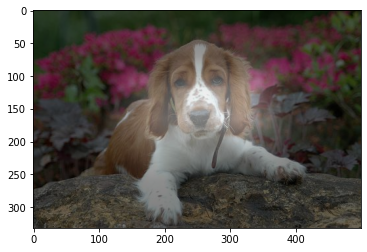

In [ ]:
# visualize_cam_on_image() 함수 사용

#type(item['image'].numpy())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.


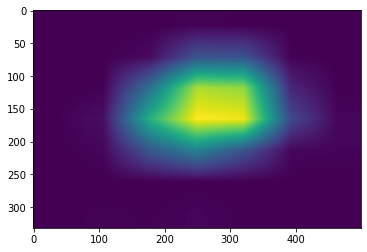

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

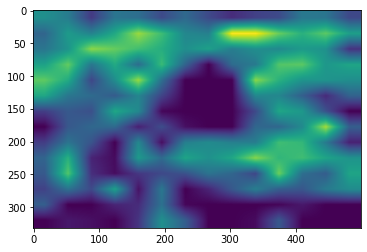

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block2_1_conv', item)
plt.imshow(grad_cam_image)
plt.show()

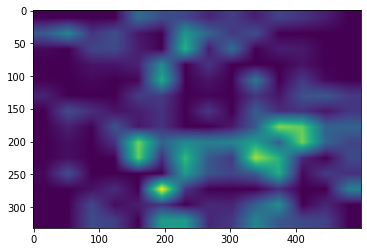

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_1_relu', item)
plt.imshow(grad_cam_image)
plt.show()


위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

## 바운딩 박스 구하기

제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

67


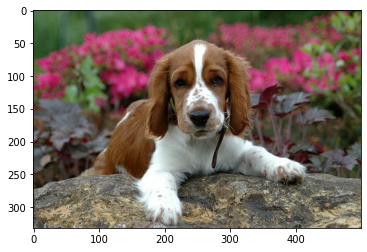

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

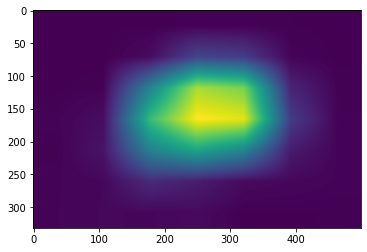

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

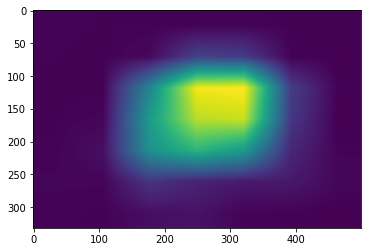

In [ ]:
cam_image2 = generate_cam(cam_model2, item)
plt.imshow(cam_image2)
plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

1)에서 얻은 바운딩 박스를 시각화해 보세요.

In [ ]:
rect = get_bbox(cam_image)
rect

array([[ 69,  80],
       [399,  -7],
       [462, 227],
       [132, 315]])

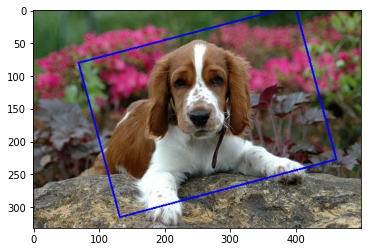

In [ ]:
#예측한 바운딩 박스
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [ ]:
item['objects']['bbox']
#(x_min, y_min, x_max, y_max)


array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.02108433734939759, 0.138, 0.9487951807228916, 0.924]

(라벨)bbox 값 구하기

In [ ]:
item['image'].shape

(332, 500, 3)

In [ ]:
image_height, image_width, _ = item['image'].shape
bbox_normalized = item['objects']['bbox'][0]

ymin = int(bbox_normalized[0] * image_height)
xmin = int(bbox_normalized[1] * image_width)
ymax = int(bbox_normalized[2] * image_height)
xmax = int(bbox_normalized[3] * image_width)

In [ ]:
rect1 = [[xmin, ymax], [xmin, ymin], [xmax,ymin],[xmax, ymax]]
rect1_np = np.array(rect1)

In [ ]:
rect1_np

array([[ 72, 328],
       [ 72,  45],
       [412,  45],
       [412, 328]])

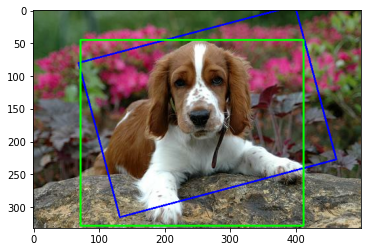

In [ ]:
#라벨의 바운딩 박스
rect = item['objects']['bbox']
image = cv2.drawContours(image, [rect1_np], 0, (0,255,0), 2)
plt.imshow(image)

iou 구하기

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
#에포크를 2로 주었을 때 결과 값
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7009452027221661

에포크 2의 결과 값: 0.7009452027221661

In [ ]:
#에포크 10
rect2 = get_bbox(cam_image2)
rect2

array([[110,  36],
       [443,  36],
       [443, 301],
       [110, 301]])

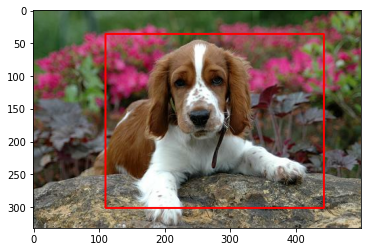

In [ ]:
#예측한 바운딩 박스
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect2], 0, (255,0,0), 2)
plt.imshow(image)
plt.show()

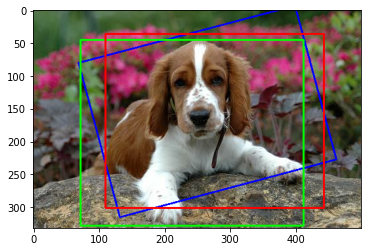

In [ ]:
#에포크2, 에포크10 예측한 바운딩 박스 + 라벨값의 바운딩 박스
image = cv2.drawContours(image, [rect1_np], 0, (0,255,0), 2)
image = cv2.drawContours(image, [rect2], 0, (255,0,0), 2)

plt.imshow(image)
plt.show()

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.10843373493975904, 0.22, 0.9066265060240963, 0.886]

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7256330491260061

에포크 10의 결과 값: 0.7256330491260061